In [2]:
# Declare whether you are on Colab or local
colab = True

In [3]:
if colab==True:
  
  #Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  #set path to data in Google Drive
  data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/All Topics"
  data_path_group = data_path[:-10]+"Topic 1/Data_Team1/" # create new data path to access files created by Team1

  #install required packages
  #!pip install duckdb
  #!pip install -U sentence-transformers


else:
    data_path_group = "../data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 1: New entity recognition

## Load data

#### Noun phrases

In [4]:
NER_entities_train_df = pd.read_csv(data_path_group+"NER/NER_entities_train.csv", index_col=0)
NER_entities_val_df = pd.read_csv(data_path_group+"NER/NER_entities_val.csv", index_col=0)
NER_entities_test_df = pd.read_csv(data_path_group+"NER/NER_entities_test.csv", index_col=0)

In [5]:
NER_entities_train_df.tail(5)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
13172372,4994,4994_204_223,programming language,management,0
13172373,4994,4994_204_223,programming language,databases,0
13172374,4994,4994_204_223,programming language,programming languages,programming language
13172375,4994,4994_204_223,programming language,globalization,0
13172376,4994,4994_204_223,programming language,IS.ABSTRACT,0


### Ontology

In [6]:
NER_ontology_train_df = pd.read_csv(data_path_group+"NER/NER_ontology_train.csv", index_col=0)
NER_ontology_val_df = pd.read_csv(data_path_group+"NER/NER_ontology_val.csv", index_col=0)
NER_ontology_test_df = pd.read_csv(data_path_group+"NER/NER_ontology_test.csv", index_col=0)

In [32]:
#Remove whitespaces
NER_ontology_train_df["synonym"] = NER_ontology_train_df.synonym.str.strip()
NER_ontology_val_df["synonym"] = NER_ontology_val_df.synonym.str.strip()
NER_ontology_test_df["synonym"] = NER_ontology_test_df.synonym.str.strip()

In [34]:
#NER_ontology_train_df.to_csv(data_path_group+"NER/NER_ontology_train.csv")
#NER_ontology_val_df.to_csv(data_path_group+"NER/NER_ontology_val.csv")
#NER_ontology_test_df.to_csv(data_path_group+"NER/NER_ontology_test.csv")

In [7]:
NER_ontology_train_df.head(5)

,entity_id,category,label,synonym
0,IS topic,domain specific entity,TOPIC,IS topic
1,IS topic,domain specific entity,TOPIC,IS topics
2,IS sourcing,domain specific entity,TOPIC,IS / IT sourcing
3,IS sourcing,domain specific entity,TOPIC,tool sourcing
4,IS sourcing,domain specific entity,TOPIC,software sourcings


## Remove entity tags from noun phrases which are not correct 

As we can see our dataframe has the lable ent_id "programming language" for all noun phrases, even though only "programming languages" is a synonym of this enitity!! This is due to the fact that Sebastian & Rolands DB only contain the labels per sentence, but not the position of this label within the sentence.
In order to train our model properly we have to create a new column where we only match the true main entity to the correct noun phrases and set all others to 0. This matching will probably not 100% accurate as some noun phrases may be split differently with our spacy model as they are in the synonyms databse, but thats a risk we have to take

In [8]:
NER_entities_train_df.head(5)

,article_id,sentence_id,ent_id,noun_phrases
0,188,188_3753_3772,videotex,which
1,188,188_3753_3772,videotex,we
2,188,188_3753_3772,videotex,an information
3,188,188_3753_3772,videotex,communication resource
4,188,188_3753_3772,videotex,the Minitel system


In [36]:
#Left Merge synonyms from ontology on entities noun phrases to get true main entity id on a noun phrase level
NER_entities_train_df = NER_entities_train_df.merge(
    NER_ontology_train_df[["synonym","entity_id"]], 
    how="left", left_on="noun_phrases", right_on="synonym").drop(columns=["synonym"]).fillna(0)

#Rename column
NER_entities_train_df.rename(columns={"entity_id": "true_ent_id"}, inplace=True)

In [37]:
# Check results
NER_entities_train_df.iloc[9:20]

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
9,188,188_3848_3883,government,This,0
10,188,188_3848_3883,government,further ampli ed,0
11,188,188_3848_3883,government,business,organizational participant
12,188,188_3848_3883,government,the infrastructure,0
13,188,188_3848_3883,government,place,0
14,188,188_3848_3883,government,which,0
15,188,188_3848_3883,government,the government,0
16,188,188_3848_3883,government,the control,0
17,188,188_3848_3883,government,individual rms,0
18,188,188_3883_3924,information superhighway,the high degree,0


As we can see this merge was working, however unfortunately we are not able to get all correct matches, because our noun phrases from spacy sometimes do not exactly match the synonym in the ontology (e.g. row 15). We could also remove stop words before merging, but for the sake of time we decided against it. 

Let's put the above code in a function so we can reuse it later

In [38]:
def correct_tagging(NER_entites_df, NER_ontology_df):

  #Left Merge synonyms from ontology on entities noun phrases to get true main entity id on a noun phrase level
  NER_entites_df = NER_entites_df.merge(
      NER_ontology_df[["synonym","entity_id"]], 
      how="left", left_on="noun_phrases", right_on="synonym").drop(columns=["synonym"]).fillna(0)

  #Rename column
  NER_entites_df.rename(columns={"entity_id": "true_ent_id"}, inplace=True)

  return NER_entites_df

In [39]:
# Lets apply them to all entities dataframes
#NER_entities_train_df = correct_tagging(NER_entities_train_df, NER_ontology_train_df)
NER_entities_val_df = correct_tagging(NER_entities_val_df, NER_ontology_val_df)
NER_entities_test_df = correct_tagging(NER_entities_test_df, NER_ontology_test_df)

In [43]:
##Store them as .csvs in Google Drive
#NER_entities_train_df.to_csv(data_path_group+"NER/NER_entities_train.csv")
#NER_entities_val_df.to_csv(data_path_group+"NER/NER_entities_val.csv")
#NER_entities_test_df.to_csv(data_path_group+"NER/NER_entities_test.csv")

## Create training datasets to fine tune models

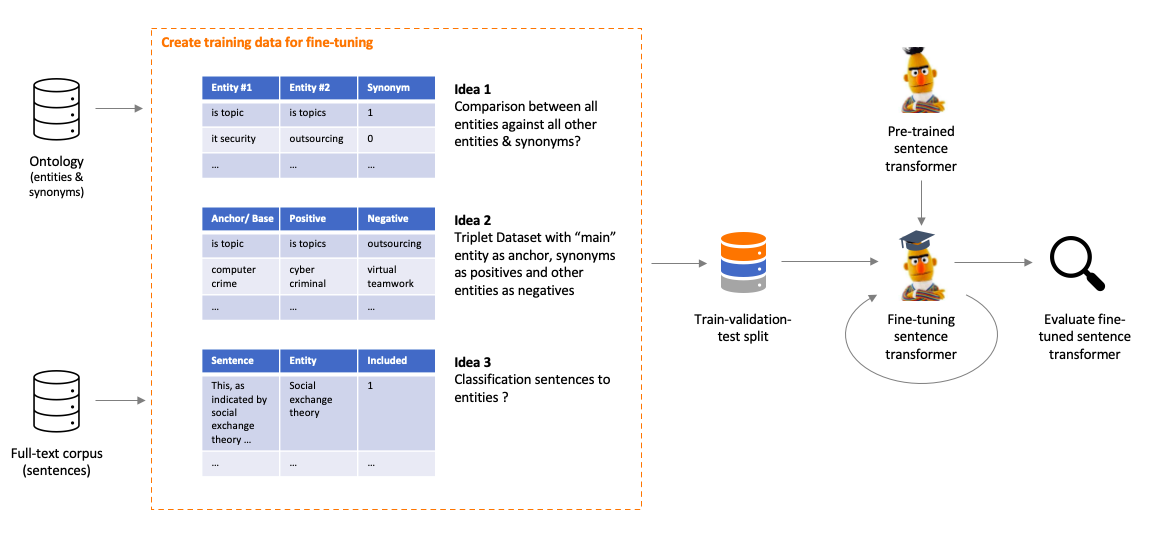

### Idea 1: Comparison entities and synonyms

In [61]:
NER_ontology_train_df.head()

,entity_id,category,label,synonym
0,IS topic,domain specific entity,TOPIC,IS topic
1,IS topic,domain specific entity,TOPIC,IS topics
2,IS sourcing,domain specific entity,TOPIC,IS / IT sourcing
3,IS sourcing,domain specific entity,TOPIC,tool sourcing
4,IS sourcing,domain specific entity,TOPIC,software sourcings


In [62]:
NER_ontology_train_df.label.value_counts()

PARTICIPANTS         237958
COLLECTION_METHOD     59969
TECHNOLOGY            38765
TOPIC                 21198
VALIDITY              16854
ANALYSIS_METHOD        3371
CONCEPTUAL_METHOD      3101
SECTOR                 2470
METRIC                 1541
MODEL_ELEMENT          1524
THEORY                  972
COMPANY_TYPE            508
SAMPLING                306
PARADIGM                243
LEVEL                    26
Name: label, dtype: int64

In [8]:
# Add new column to label whether entity_id and synonym are indeed synonmys
NER_ontology_train_df["is_synonym"] = 1

In [9]:
#Filter out identical rows (main entity and synonym is the same word/phrase)
NER_ontology_train_df = NER_ontology_train_df.loc[NER_ontology_train_df.entity_id!=NER_ontology_train_df.synonym]

In [10]:
NER_ontology_train_df.head(3)

,entity_id,category,label,synonym,is_synonym
1,IS topic,domain specific entity,TOPIC,IS topics,1
2,IS sourcing,domain specific entity,TOPIC,IS / IT sourcing,1
3,IS sourcing,domain specific entity,TOPIC,tool sourcing,1


Now our dataset only consists of positive examples. In order to also give the model some negative examples we will randomly draw 100 other entity id from the training set which do not belong to this entity, but are in the same `category` (to ensure some more or less meaningful relation)

In [11]:
NER_ontology_train_unique_ents_df = NER_ontology_train_df[["entity_id", "category", "label"]].drop_duplicates("entity_id")

In [12]:
NER_ontology_train_unique_ents_df["synonym"] = NER_ontology_train_unique_ents_df.apply(lambda x: np.random.choice(NER_ontology_train_df[(NER_ontology_train_df.category==x.category)&(NER_ontology_train_df.entity_id!=x.entity_id)].entity_id.unique(),100, replace=True), axis=1)

In [13]:
NER_ontology_train_unique_ents_df["is_synonym"]=0

In [14]:
NER_ontology_train_unique_ents_df = NER_ontology_train_unique_ents_df.explode("synonym")

In [15]:
# Drop duplicates (because we draw with replacement)
NER_ontology_train_unique_ents_df = NER_ontology_train_unique_ents_df.drop_duplicates()

In [16]:
NER_ontology_train_unique_ents_df

,entity_id,category,label,synonym,is_synonym
1,IS topic,domain specific entity,TOPIC,Hulu,0
1,IS topic,domain specific entity,TOPIC,electronic finance,0
1,IS topic,domain specific entity,TOPIC,news agency,0
1,IS topic,domain specific entity,TOPIC,document database,0
1,IS topic,domain specific entity,TOPIC,foundry industry,0
...,...,...,...,...,...
16870,common-method variance,methodological entity,VALIDITY,goodness of fit statistical test,0
16870,common-method variance,methodological entity,VALIDITY,Student's t-test,0
16870,common-method variance,methodological entity,VALIDITY,BERT,0
16870,common-method variance,methodological entity,VALIDITY,instrumental variables estimation,0


In [17]:
NER_ontology_train_df = pd.concat([NER_ontology_train_df, NER_ontology_train_unique_ents_df], axis=0).reset_index(drop=True)

In [18]:
#shuffle
NER_ontology_train_df = NER_ontology_train_df.sample(frac=1)

In [19]:
NER_ontology_train_df.is_synonym.value_counts()

1    386914
0    177860
Name: is_synonym, dtype: int64

In [20]:
NER_ontology_train_df

,entity_id,category,label,synonym,is_synonym
410538,digital economy,domain specific entity,TOPIC,banking industry,0
60151,individual participant,study object,PARTICIPANTS,information and research research managers,1
241573,individual participant,study object,PARTICIPANTS,junior financial agents ( )S,1
217700,individual participant,study object,PARTICIPANTS,junior and IS financial manager,1
228572,individual participant,study object,PARTICIPANTS,research and business knowledge worker,1
...,...,...,...,...,...
524184,web technology,domain specific entity,TECHNOLOGY,Advanced Encryption Standard,0
130190,individual participant,study object,PARTICIPANTS,business and chief business assistant,1
260726,organizational participant,study object,PARTICIPANTS,international medium up ( ),1
79879,individual participant,study object,PARTICIPANTS,business and research bidders,1


In [21]:
#NER_ontology_train_df.to_csv(data_path_group+"NER/Synonym_Dataset/NER_ontology_train_df_syn.csv")

#### Create function

Since this is working now. Let's put it into a function to reuse later: 

In [4]:
def rand_sample_false_syn(x, ontology_df):

    try:
        return np.random.choice(ontology_df[
                                (ontology_df.category==x.category)&
                                (ontology_df.entity_id!=x.entity_id)
                                ]
                            .entity_id.unique(),100, replace=True)    
    
    except:
        return np.random.choice(ontology_df[
                        #(ontology_df.category==x.category)&
                        (ontology_df.entity_id!=x.entity_id)
                        ]
                    .entity_id.unique(),100, replace=True)    

In [5]:
def create_synonyms_dataset(ontology_df, return_false_syn=True):
    
    #Filter out identical rows (main entity and synonym is the same word/phrase)
    ontology_df = ontology_df.loc[ontology_df.entity_id!=ontology_df.synonym]

    # Add new column to label whether entity_id and synonym are indeed synonmys
    ontology_df["is_synonym"] = 1

    ontology_false_synonyms_df = ontology_df[["entity_id", "category", "label"]].drop_duplicates("entity_id")

    ontology_false_synonyms_df["synonym"] = ontology_false_synonyms_df.apply(
                                        lambda x: rand_sample_false_syn(x,ontology_df), axis=1)


    ontology_false_synonyms_df["is_synonym"]=0

    ontology_false_synonyms_df = ontology_false_synonyms_df.explode("synonym")

    # Drop duplicates (because we draw with replacement)
    ontology_false_synonyms_df = ontology_false_synonyms_df.drop_duplicates()

    ontology_df = pd.concat([ontology_df, ontology_false_synonyms_df], axis=0).reset_index(drop=True).sample(frac=1)

    if return_false_syn==False:
        return ontology_df

    return ontology_df, ontology_false_synonyms_df

In [24]:
NER_ontology_val_df_syn, ontology_false_syn_val_df = create_synonyms_dataset(NER_ontology_val_df)
NER_ontology_test_df_syn, ontology_false_syn_test_df = create_synonyms_dataset(NER_ontology_test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [25]:
#NER_ontology_val_df_syn.to_csv(data_path_group+"NER/Synonym_Dataset/NER_ontology_val_df_syn.csv")
#NER_ontology_test_df_syn.to_csv(data_path_group+"NER/Synonym_Dataset/NER_ontology_test_df_syn.csv")

### Idea 2: Triplet dataset
Triplet dataset with "main" entity as anchor, synonyms as positives and other entities as negatives

In [26]:
NER_ontology_train_triplets = NER_ontology_train_df.merge(NER_ontology_train_unique_ents_df, how="inner", on="entity_id")

In [27]:
NER_ontology_train_triplets = NER_ontology_train_triplets.loc[NER_ontology_train_triplets.is_synonym_x==1]

In [28]:
NER_ontology_train_triplets.shape

(17103121, 9)

This would be a very big triplet dataset ^^. Maybe lets just keep one triplet per main-entity and real_synonym pair ...

In [29]:
# shuffle and then only keep first row for duplicate entity id and synonym_x
NER_ontology_train_triplets = NER_ontology_train_triplets.sample(frac=1).drop_duplicates(["entity_id", "synonym_x"]).loc[:,["entity_id", "synonym_x", "synonym_y"]].reset_index(drop=True)

In [30]:
# Much better
NER_ontology_train_triplets.shape

(386914, 3)

In [31]:
# Rename columns
NER_ontology_train_triplets.columns = ["entity_id", "positive_example", "negative_example"]

In [32]:
NER_ontology_train_triplets.shape

(386914, 3)

In [33]:
NER_ontology_train_triplets.entity_id.value_counts()

individual participant                           228593
survey                                            42097
three validities                                  16001
online learning system                            10074
communication service infrastructure               8931
                                                  ...  
web crawling                                          1
wide area network                                     1
social penetration theory                             1
structured systems analysis and design method         1
automated clearing house                              1
Name: entity_id, Length: 1975, dtype: int64

A lot better than before, but there are some entities which appear way more often than others! (Because they have a very high number of synonyms). Let's further decrease the size of this dataset by dropping duplicates of entity_id and negative example

In [34]:
NER_ontology_train_triplets = NER_ontology_train_triplets.drop_duplicates(["entity_id", "negative_example"])

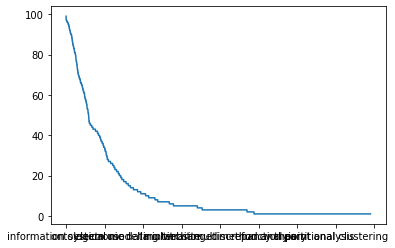

In [35]:
NER_ontology_train_triplets.entity_id.value_counts().plot()

Still not perfectly balanced, but definetly an improvement to before

In [36]:
NER_ontology_train_triplets.shape

(24205, 3)

In [38]:
#NER_ontology_train_triplets.to_csv(data_path_group+"NER/Triplets_Dataset/NER_ontology_train_triplets.csv")

#### Create function

Now that this code is working as well. Let's put it into a function for future use

In [6]:
def create_triplets_dataset(ontology_df, ontology_false_syn_df):

    ontology_triplets_df = ontology_df.merge(ontology_false_syn_df, how="inner", on="entity_id")

    ontology_triplets_df = ontology_triplets_df.loc[ontology_triplets_df.is_synonym_x==1]

    ontology_triplets_df = ontology_triplets_df.sample(frac=1)\
                                .drop_duplicates(["entity_id", "synonym_x"])\
                                .loc[:,["entity_id", "synonym_x", "synonym_y"]]\
                                .reset_index(drop=True)

    # Rename columns
    ontology_triplets_df.columns = ["entity_id", "positive_example", "negative_example"]

    ontology_triplets_df = ontology_triplets_df.drop_duplicates(["entity_id", "negative_example"])

    return ontology_triplets_df


In [40]:
NER_ontology_val_triplets = create_triplets_dataset(NER_ontology_val_df_syn, ontology_false_syn_val_df)
NER_ontology_test_triplets = create_triplets_dataset(NER_ontology_test_df_syn, ontology_false_syn_test_df)

In [42]:
#NER_ontology_val_triplets.to_csv(data_path_group+"NER/Triplets_Dataset/NER_ontology_val_triplets.csv")
#NER_ontology_test_triplets.to_csv(data_path_group+"NER/Triplets_Dataset/NER_ontology_test_triplets.csv")

### Idea 3: Classification dataset for each sentence

For this Dataset we can just take the sentences from Drive and filter out all the sentences from test and val

# Task 2: Synonym Detection

## Load data

#### Noun phrases

In [7]:
SynDet_entities_train_df = pd.read_csv(data_path_group+"SynDet/SynDet_entities_train.csv", index_col=0)
SynDet_entities_val_df = pd.read_csv(data_path_group+"SynDet/SynDet_entities_val.csv", index_col=0)
SynDet_entities_test_df = pd.read_csv(data_path_group+"SynDet/SynDet_entities_test.csv", index_col=0)

In [45]:
SynDet_entities_train_df.tail(5)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
13826402,4994,4994_204_223,programming language,management,0
13826403,4994,4994_204_223,programming language,databases,0
13826404,4994,4994_204_223,programming language,programming languages,programming language
13826405,4994,4994_204_223,programming language,globalization,0
13826406,4994,4994_204_223,programming language,IS.ABSTRACT,0


### Ontology

In [8]:
SynDet_ontology_train_df = pd.read_csv(data_path_group+"SynDet/SynDet_ontology_train.csv", index_col=0)
SynDet_ontology_val_df = pd.read_csv(data_path_group+"SynDet/SynDet_ontology_val.csv", index_col=0)
SynDet_ontology_test_df = pd.read_csv(data_path_group+"SynDet/SynDet_ontology_test.csv", index_col=0)

In [48]:
#Remove whitespaces
SynDet_ontology_train_df["synonym"] = SynDet_ontology_train_df.synonym.str.strip()
SynDet_ontology_val_df["synonym"] = SynDet_ontology_val_df.synonym.str.strip()
SynDet_ontology_test_df["synonym"] = SynDet_ontology_test_df.synonym.str.strip()

In [47]:
SynDet_ontology_train_df.head(5)

,entity_id,category,label,synonym
0,sampling,methodological entity,SAMPLING,sampling
0,data analysis method,methodological entity,ANALYSIS_METHOD,data analysis investigation
0,statistical metric,methodological entity,METRIC,statistical metric
0,data collection method,research method,COLLECTION_METHOD,data collection analyses
0,economic sector,domain specific entity,SECTOR,economic sectors


In [49]:
#SynDet_ontology_train_df.to_csv(data_path_group+"SynDet/SynDet_ontology_train.csv")
#SynDet_ontology_val_df.to_csv(data_path_group+"SynDet/SynDet_ontology_val.csv")
#SynDet_ontology_test_df.to_csv(data_path_group+"SynDet/SynDet_ontology_test.csv")

## Remove entity tags from noun phrases which are not correct 

In [57]:
# Lets apply them to all entities dataframes
SynDet_entities_train_df = correct_tagging(SynDet_entities_train_df, SynDet_ontology_train_df)
SynDet_entities_val_df = correct_tagging(SynDet_entities_val_df, SynDet_ontology_val_df)
SynDet_entities_test_df = correct_tagging(SynDet_entities_test_df, SynDet_ontology_test_df)

In [60]:
##Store them as .csvs in Google Drive
#SynDet_entities_train_df.to_csv(data_path_group+"SynDet/SynDet_entities_train.csv")
#SynDet_entities_val_df.to_csv(data_path_group+"SynDet/SynDet_entities_val.csv")
#SynDet_entities_test_df.to_csv(data_path_group+"SynDet/SynDet_entities_test.csv")

## Create training datasets to fine tune models

### Idea 1: Comparison entities and synonyms

In [9]:
SynDet_ontology_train_df_syn, SynDet_ontology_false_syn_train_df = create_synonyms_dataset(SynDet_ontology_train_df)
SynDet_ontology_val_df_syn, SynDet_ontology_false_syn_val_df = create_synonyms_dataset(SynDet_ontology_val_df)
SynDet_ontology_test_df_syn, SynDet_ontology_false_syn_test_df = create_synonyms_dataset(SynDet_ontology_test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [46]:
SynDet_ontology_train_df_syn

,entity_id,category,label,synonym,is_synonym
235036,individual participant,study object,PARTICIPANTS,usable and information agent,1
189726,individual participant,study object,PARTICIPANTS,professional and senior research executives,1
291037,individual participant,study object,PARTICIPANTS,business and IS IS informant,1
31468,survey,research method,COLLECTION_METHOD,telephone based postal questionnaire descriptions,1
288690,individual participant,study object,PARTICIPANTS,business and professional individual,1
...,...,...,...,...,...
429344,year 2000 date conversion,domain specific entity,TOPIC,intellectual property,0
473389,generalized additive model,methodological entity,ANALYSIS_METHOD,QDA Miner Lite,0
401338,rule-based representation,domain specific entity,TECHNOLOGY,IT centralization,0
90436,individual participant,study object,PARTICIPANTS,multicultural and professional citizens,1


In [47]:
#SynDet_ontology_train_df_syn.to_csv(data_path_group+"SynDet/Synonym_Dataset/SynDet_ontology_train_df_syn.csv")
#SynDet_ontology_val_df_syn.to_csv(data_path_group+"SynDet/Synonym_Dataset/SynDet_ontology_val_df_syn.csv")
#SynDet_ontology_test_df_syn.to_csv(data_path_group+"SynDet/Synonym_Dataset/SynDet_ontology_test_df_syn.csv")

### Idea 2: Triplet dataset
Triplet dataset with "main" entity as anchor, synonyms as positives and other entities as negatives

In [10]:
SynDet_ontology_train_triplets = create_triplets_dataset(SynDet_ontology_train_df_syn, SynDet_ontology_false_syn_train_df)
SynDet_ontology_val_triplets = create_triplets_dataset(SynDet_ontology_val_df_syn, SynDet_ontology_false_syn_val_df)
SynDet_ontology_test_triplets = create_triplets_dataset(SynDet_ontology_test_df_syn, SynDet_ontology_false_syn_test_df)

In [11]:
SynDet_ontology_train_triplets

,entity_id,positive_example,negative_example
0,electronic health record,online medical records,postal banking
1,archival research,government data sources analysis,action design research
2,communication service infrastructure,digital enabled communication computers,model driven development
3,survey,quantitative based supervised polling techniques,hierarchical Markov model
4,three validities,test convergent and design validity,binary classification
...,...,...,...
315756,Qualtrics,Qualtricss,multi divisional corporation
323058,multi national corporation,multi national businesses,startup
329137,business cooperation,business cooperations,individual participant
329856,Prolific Academic,Prolific,Amazon Mechanical Turk


In [12]:
#SynDet_ontology_train_triplets.to_csv(data_path_group+"SynDet/Triplets_Dataset/SynDet_ontology_train_triplets.csv")
#SynDet_ontology_val_triplets.to_csv(data_path_group+"SynDet/Triplets_Dataset/SynDet_ontology_val_triplets.csv")
#SynDet_ontology_test_triplets.to_csv(data_path_group+"SynDet/Triplets_Dataset/SynDet_ontology_test_triplets.csv")